<a href="https://colab.research.google.com/github/antoniobelotti/gpu_aco_tsp/blob/master/gpu_aco_tsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Sep  5 09:49:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


#Setup

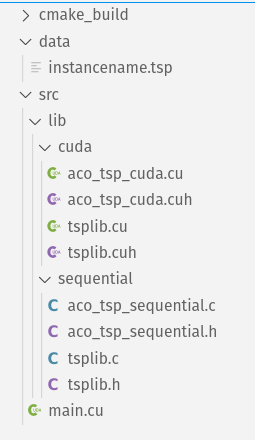

In [3]:
# Comment this to enable output
%%capture 

# remove default colab stuff
!rm -rf sample_data 

#create directory structure
!mkdir -p src/lib/cuda
!mkdir -p src/lib/sequential

# download TSPLIB intsances
!git clone https://github.com/mastqe/tsplib.git data

# Install nvcc colab plugin
!pip install git+https://github.com/andreinechaev/nvcc4jupyter
%load_ext nvcc_plugin

#Code

##Sequential implementation

###Code to read TSPLIB instances





In [4]:
%%cuda --name lib/sequential/tsplib.h
#ifndef TSPLIB_H
#define TSPLIB_H

#define ASCII_SLASH 47
#define ASCII_0 48
#define ASCII_9 57

typedef struct node_t{
    int id;
    int x;
    int y;
} Node;

typedef struct TSPInstance_t {
    const int numOfNodes;
    Node *nodes;
    float *edgeCosts;
} TSPInstance;


TSPInstance tsp_instance_read(const char *filename);
void tsp_instance_free(TSPInstance *instance);

#endif //TSPLIB_H

'File written in /content/src/lib/sequential/tsplib.h'

In [5]:
%%cuda --name lib/sequential/tsplib.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>

#include "tsplib.h"


TSPInstance tsp_instance_read(const char *filename) {
    printf("Reading tsplib instances from %s\n", filename);

    FILE *f = fopen(filename, "r");
    if (f == NULL) {
        printf("Error reading file!");
        exit(1);
    }

    unsigned long filename_len = strlen(filename);
    const char *s = filename + filename_len; // pointer to last char
    for (; *s != ASCII_SLASH; s--); // scan backwards until / is found
    for (; *s < ASCII_0 || *s > ASCII_9; s++); // scan forward until a digit is found

    int num_of_nodes = strtol(s, NULL, 10);

    char line_buff[64];
    Node *nodes = malloc(sizeof *nodes * num_of_nodes);

    while (fgets(line_buff, sizeof line_buff, f) != NULL &&
           strncmp(line_buff, "NODE_COORD_SECTION", strlen("NODE_COORD_SECTION")) != 0);

    while (fgets(line_buff, sizeof line_buff, f) != NULL && strncmp(line_buff, "EOF", 3) != 0) {

        int progr, x, y;

        char *buff_cursor;
        progr = strtol(line_buff, &buff_cursor, 10);
        x = strtol(buff_cursor, &buff_cursor, 10);
        y = strtol(buff_cursor, &buff_cursor, 10);

        // convert to 0-indexed
        progr -= 1;

        nodes[progr].id = progr;
        nodes[progr].x = x;
        nodes[progr].y = y;

    }

    fclose(f);

    TSPInstance instance = {.numOfNodes = num_of_nodes, .nodes = nodes};

    float *edge_cost = malloc(sizeof(int) * num_of_nodes * num_of_nodes);

    float deltaX, deltaY;
    Node n1, n2;
    float weight;
    for (int i = 0; i < num_of_nodes; i++) {
        for (int j = i; j < num_of_nodes; j++) {
            n1 = nodes[i];
            n2 = nodes[j];

            deltaX = (float) (n1.x - n2.x);
            deltaY = (float) (n1.y - n2.y);

            weight = floorf(sqrtf(powf(deltaX, 2) + powf(deltaY,2)));

            edge_cost[n1.id * num_of_nodes + n2.id] = weight;
            edge_cost[n2.id * num_of_nodes + n1.id] = weight;
        }
    }

    instance.edgeCosts = edge_cost;
    return instance;
}

void tsp_instance_free(TSPInstance *instance) {
    free(instance->nodes);
    free(instance->edgeCosts);
}

'File written in /content/src/lib/sequential/tsplib.cu'

In [6]:
!mv src/lib/sequential/tsplib.cu src/lib/sequential/tsplib.c

###Algorithm

In [7]:
%%cuda --name lib/sequential/aco_tsp_sequential.h
#ifndef ACO_TSP_SEQUENTIAL_H
#define ACO_TSP_SEQUENTIAL_H

#include "tsplib.h"

void aco_tsp_sequential(
    TSPInstance instance,
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
);

#endif // ACO_TSP_SEQUENTIAL_H

'File written in /content/src/lib/sequential/aco_tsp_sequential.h'

In [8]:
# cuda plugin requires .cu extension... change it later to .c
# using %%cuda instead of %%writefile becaus writefile disables syntax highlighting

%%cuda --name lib/sequential/aco_tsp_sequential.cu
#include <stdio.h>
#include <limits.h>
#include <stdbool.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

#include "aco_tsp_sequential.h"

float randf(float right) {
    return ((float) rand() / (float) RAND_MAX) * right;
}

float pheromone_initialization(float *pheromones, const float *edge_cost, int N) {
    /* BUILD greedy path */
    int path[N];
    float path_cost = 0;
    bool visited[N];

    int id_first_node = (int) random() % N;
    visited[id_first_node] = true;

    int current_node = id_first_node;
    for (int i = 1; i < N; i++) {
        int closest_node = -1;
        float closest_node_cost = (float) INT_MAX;

        for (int j = 0; j < N; ++j) {
            if (!visited[j] && current_node != j && edge_cost[current_node * N + j] < closest_node_cost) {
                closest_node_cost = edge_cost[current_node * N + j];
                closest_node = j;
            }
        }

        path[current_node] = closest_node;
        visited[closest_node] = true;
        current_node = closest_node;
        path_cost += closest_node_cost;
    }

    /* set pheromone to N/greedy path cost */
    for (int i = 0; i < N * N; ++i)
        pheromones[i] = (float) N / (float) path_cost;

    
}

void build_paths(int *ant_paths_mx, float *pheromone_trails, float *edge_costs, int N, const float ALPHA, const float BETA) {
    for (int i = 0; i < N * N; i++) ant_paths_mx[i] = -1;

    bool *unvisited_nodes_mx = malloc(sizeof *unvisited_nodes_mx * N * N);
    for (int i = 0; i < N * N; i++) unvisited_nodes_mx[i] = true;

    float *edge_fitness_mx = malloc(sizeof *edge_fitness_mx *N * N);
    for (int r = 0; r < N; ++r)
      for (int c = 0; c < N; ++c)
        edge_fitness_mx[r * N + c] =
          r == c ? 0 : powf(pheromone_trails[r * N + c], ALPHA) / powf(edge_costs[r * N + c], BETA);

    // build every ant's path
    for (int ant_id = 0; ant_id < N; ++ant_id) {
        // select random starting node
        int id_first_node = (int) random() % N;
        unvisited_nodes_mx[ant_id * N + id_first_node] = false;

        int current_node_id = id_first_node;
        for (int visited_nodes = 1; visited_nodes < N; visited_nodes++) {
            float prefix_sum[N];
            for (int j = 0; j < N; j++) {
                bool mask = unvisited_nodes_mx[ant_id * N + j];
                float fitness = edge_fitness_mx[current_node_id * N + j];
                prefix_sum[j] = (j > 0 ? prefix_sum[j - 1] : 0.0f) + ((float) mask * fitness);
            }

            float random_number = randf(prefix_sum[N - 1]);
            for (int j = 0; j < N; ++j) {
                float ps_prev = j > 0 ? prefix_sum[j - 1] : 0.0f;
                if (random_number >= ps_prev && random_number < prefix_sum[j]) {
                    ant_paths_mx[ant_id * N + current_node_id] = j;
                    unvisited_nodes_mx[ant_id * N + j] = false;
                    current_node_id = j;
                    break;
                }
            }
        }

        ant_paths_mx[ant_id * N + current_node_id] = id_first_node;
    }

    free(edge_fitness_mx);
    free(unvisited_nodes_mx);
}

int update_paths_len(const int *ant_paths_mx, float *ant_paths_len, const float *edge_cost, int N) {
    // keep track of the ant id with the shortest path
    int best_path_ant_id = -1;
    float best_path = (float) INT_MAX;

    for (int ant_id = 0; ant_id < N; ++ant_id) {
        // calculate cost of ant(ant_id) path
        ant_paths_len[ant_id] = 0;
        int current_node = 0;
        int next_node = ant_paths_mx[ant_id * N + current_node];

        for (int i = 0; i < N; ++i) {
            ant_paths_len[ant_id] += edge_cost[current_node * N + next_node];
            current_node = next_node;
            next_node = ant_paths_mx[ant_id * N + current_node];
        }

        if (ant_paths_len[ant_id] < best_path) {
            best_path = ant_paths_len[ant_id];
            best_path_ant_id = ant_id;
        }
    }

    return best_path_ant_id;
}

void pheromone_evaporation(float *pheromones, int N, const float RHO, const float PHEROMONE_LB) {
    for (int i = 0; i < N * N; ++i)
        pheromones[i] = fmaxf((1 - RHO) * pheromones[i], PHEROMONE_LB);
}

void pheromone_update(float *pheromones, const int *paths, const float *paths_len, int N, const float Q, const float PHEROMONE_LB) {
    for (int i = 0; i < N; ++i) {
        for (int j = i; j < N; ++j) {
            float previous_pheromone_value = pheromones[i * N + j];
            float addition = 0.0f;
            for (int ant_id = 0; ant_id < N; ++ant_id)
                // if edge (i,j) is in path of ant ant_id
                if (paths[ant_id * N + i] == j)
                    addition += Q / (float) paths_len[ant_id];


            pheromones[i * N + j] = fmaxf(previous_pheromone_value + addition, PHEROMONE_LB);
        }
    }
}

void aco_tsp_sequential(
    TSPInstance instance,
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
)
{
    int N = instance.numOfNodes;
    float *pheromone_mx = malloc(sizeof *pheromone_mx * N * N);
    int   *paths_mx = malloc(sizeof *paths_mx *N * N);
    float paths_len[N];
    int best_path[N];
    float best_path_len = (float) INT_MAX;

    pheromone_initialization(pheromone_mx, instance.edgeCosts, N);
    int stagnation_counter = 0;
    for (int iter = 0; iter < MAX_ITERATIONS && stagnation_counter < STAGNATION_THRESHOLD; ++iter, ++stagnation_counter) {
        printf("Generation %d of %d", iter + 1, MAX_ITERATIONS);
        fflush(stdout);
      
        build_paths(paths_mx, pheromone_mx, instance.edgeCosts, N, ALPHA, BETA);
        int current_iteration_best_ant = update_paths_len(paths_mx, paths_len, instance.edgeCosts, N);

        pheromone_evaporation(pheromone_mx, N, RHO, PHEROMONE_LB);
        pheromone_update(pheromone_mx, paths_mx, paths_len, N, Q, PHEROMONE_LB);

        if (paths_len[current_iteration_best_ant] < best_path_len) {
            best_path_len = paths_len[current_iteration_best_ant];

            // save best path
            for (int l = 0; l < instance.numOfNodes; ++l)
                best_path[l] = paths_mx[current_iteration_best_ant * N + l];

            // there's an improvement reset stagnation counter
            stagnation_counter = 0;
        }

        printf("\r");
        fflush(stdout);
    }
    
    free(pheromone_mx);
    free(paths_mx);
    
    char *prefix = stagnation_counter == STAGNATION_THRESHOLD ? "Stopped for stagnation!\n" : "";
    printf("%sBest Path has len: %f\n", prefix, best_path_len);
    for (int j = 0; j < instance.numOfNodes; ++j) printf("%d,", best_path[j] + 1);
    printf("\n");
    fflush(stdout);
}


'File written in /content/src/lib/sequential/aco_tsp_sequential.cu'

In [9]:
!mv /content/src/lib/sequential/aco_tsp_sequential.cu /content/src/lib/sequential/aco_tsp_sequential.c

##GPU implementation

In [10]:
%%cuda --name lib/cuda/common.h
#include <sys/time.h>
#include <stdio.h>

#ifndef _COMMON_H
#define _COMMON_H

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

#define CHECK_CURAND(call)                                                     \
{                                                                              \
    curandStatus_t err;                                                        \
    if ((err = (call)) != CURAND_STATUS_SUCCESS)                               \
    {                                                                          \
        fprintf(stderr, "Got CURAND error %d at %s:%d\n", err, __FILE__,       \
                __LINE__);                                                     \
        exit(1);                                                               \
    }                                                                          \
}

#endif // _COMMON_H

'File written in /content/src/lib/cuda/common.h'

### Algorithm

In [11]:
%%cuda --name lib/cuda/aco_tsp_cuda.h
#ifndef ACO_TSP_CUDA_H
#define ACO_TSP_CUDA_H

#include <curand_kernel.h>

#include "../sequential/tsplib.h"
#include "./common.h"

#define DIV_ROUNDUP(NUM,DEN) ((NUM +(DEN-1))/DEN)

void aco_tsp_cuda(
    TSPInstance instance, 
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
);

#endif // ACO_TSP_CUDA_H

'File written in /content/src/lib/cuda/aco_tsp_cuda.h'

In [23]:
  %%cuda --name lib/cuda/aco_tsp_cuda.cu
#include <stdio.h>
#include <iostream>
#include <assert.h>

#include "aco_tsp_cuda.h"

typedef enum { SCAN_INCLUSIVE, SCAN_EXCLUSIVE } PRESCAN_TYPE;

__global__ void pheromone_reset(float *pheromone_mx, const int N, const float PHEROMONE_LB){
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < N*N)
      pheromone_mx[idx] = PHEROMONE_LB;
}

__global__ void init_random_states(curandState *randStates, const int bound){
  const int gtid =blockIdx.x * blockDim.x + threadIdx.x;
  if(gtid < bound)
    curand_init(gtid, 0, 0, &randStates[gtid]);
}

__global__ void population_reset(
  int *paths_mx, 
  bool *unvisited_nodes_mx,
  int *ant_first_node, 
  int *ant_current_position, 
  curandState *randStates, 
  const int N
){
  const int gtid = blockIdx.x * blockDim.x + threadIdx.x;

  if (gtid > N*N)
    return;

  paths_mx[gtid] = -1;

  const int antId = gtid / N;
  const int colId = gtid % N;
  if (colId==0){
    // abs is necessary because rand returns unsigned, and casting to signed gives overflow (negative numbers)
    const int firstRandomNodeId = abs((int) curand(&randStates[gtid]) %N);
    ant_first_node[antId] = firstRandomNodeId;
    ant_current_position[antId] = firstRandomNodeId;
    unvisited_nodes_mx[antId*N + firstRandomNodeId] = false;
  }
}

__global__ void unvisited_node_reset(bool *unvisited_node_mx, const int N){
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < N*N)
      unvisited_node_mx[idx] = true;
}

__global__ void edge_fitness_update(float *edge_fitness_mx, float *pheromone_mx, float *edge_costs_mx, const int N, const float ALPHA, const float BETA){
    const int gidx = blockIdx.x * blockDim.x + threadIdx.x;

    float edge_cost = edge_costs_mx[gidx];
    float pheromone = pheromone_mx[gidx];
    if (gidx < N*N && edge_cost>0 && pheromone>0)
      edge_fitness_mx[gidx] = powf(pheromone, ALPHA) / powf(edge_cost, BETA);
}

/*
  prescan (in-place)
  --------------------------------------------------------------------------------
  Slightly modified version of Blelloch's prefix scan to allow for inclusive scan.
  Pretend the array to sum is always a multiple of blocksize: parameter bound will 
    prevent illigel access to memory. Out of bound data in the original array
    will be represented in shared memory with a 0 (which is neutral to prefix sum)
    so the method can handle arrays of arbitrary size with minor modifications 
    (check if global thread id < bound).

  LAUNCH PARAMETERS: 
    Having N elements. Block size = B:
      ceil(N/B)   blocks 
      b/2         threads 
      (N/B)+1     floats in shared memory
  PARAMETERS:
    *data         array to prefix sum
    n             number of elements in each block
    *blockSum     output of each block final sum. Used to calculate prescan with multiple blocks.
    SCAN_TYPE     flag to specify is sum is inlcusive or exclusive
    bound         number of elements in the entire array
*/
__global__ void prescan(float *data, const int n, float *blockSum, const PRESCAN_TYPE SCAN_TYPE, const int bound) { 
  extern __shared__ float sm[];
  
  const int tid = threadIdx.x;
  const int gtid = blockIdx.x*blockDim.x + threadIdx.x;
  int offset = 1;
    
  /* Load input into shared memory. Threads that exceed the actual array size
  *  are zeroed out so they do not influence the correct scan result.
  */
  sm[2*tid] = 0;
  sm[2*tid+1] = 0;
  if(2*gtid < bound)
    sm[2*tid] = data[2*gtid]; 
  if(2*gtid +1 < bound)
    sm[2*tid+1] = data[2*gtid+1];
  
  // build sum in place up the tree
  for (int d = n>>1; d > 0; d >>= 1) {
    __syncthreads();

    if (tid < d) { 
      int ai = offset*(2*tid+1)-1;
      int bi = offset*(2*tid+2)-1;
      sm[bi] += sm[ai];
    }
    offset *= 2;
  }

  if (tid == 0) { 
    if(SCAN_TYPE == SCAN_INCLUSIVE)
      sm[n] = sm[n-1]; 

    if(blockSum!=NULL)
      blockSum[blockIdx.x] = sm[n-1];

    sm[n-1] = 0.0f;
  }

  // traverse down tree & build scan 
  for (int d = 1; d < n; d *= 2) {      
    offset >>= 1;
    __syncthreads();
    if (tid < d) {
      int ai = offset*(2*tid+1)-1;
      int bi = offset*(2*tid+2)-1;
      float t = sm[ai]; sm[ai] = sm[bi]; sm[bi] += t;
    }
  }
  
  __syncthreads();

  int shift=0;
  if(SCAN_TYPE == SCAN_INCLUSIVE)
    shift =1;

  if(2*gtid < bound)
    data[2*gtid] = sm[2*tid+shift];
  if(2*gtid +1 < bound)
    data[2*gtid+1] = sm[2*tid+1+shift];
}


__global__ void apply_increment(float *cumsum, float *increment, const int n){
  int gidx = blockIdx.x*blockDim.x +threadIdx.x;

  if(gidx < n)
    cumsum[gidx] += increment[blockIdx.x];
}

__global__ void apply_mask(float *data, bool *mask, const int N){
    const int gtid = blockIdx.x*blockDim.x + threadIdx.x;

    if (gtid<N)
      data[gtid] *= mask[gtid];
}

__global__ void select_node(
  float *fitness, 
  float *randomNumber,
  int *antPathsMx,
  bool *unvisited_nodes_mx,
  int *antsCurrentPosition,
  const int N,
  const int antId
){
  extern __shared__ float sm[];
  const int gtid = blockDim.x*blockIdx.x + threadIdx.x;
  const int tid = threadIdx.x;

  if (gtid >= N)
    return;

  /* compiler will do its magic to avoid branching */
  if(tid==0)
    if(gtid==0)
      sm[tid] = 0.0f;
    else
      sm[tid] = fitness[gtid-1];
  
  sm[tid+1] = fitness[gtid];
  __syncthreads();

  // for the properties of the prefix sum and the range of the random number, 
  // only one thread will enter this if

  if(randomNumber[0] >= sm[tid] && randomNumber[0] < sm[tid+1]){
    int antCurrentNodeId = antsCurrentPosition[antId];
    int selectedNodeId = gtid;
    
    // update ant path
    antPathsMx[antId*N + antCurrentNodeId] = selectedNodeId; 

    // set node as visited
    unvisited_nodes_mx[antId*N + selectedNodeId] = false;

    // update current node
    antsCurrentPosition[antId] = selectedNodeId;
  }

  if(gtid == 0 && randomNumber[0]==0.0){
    int antCurrentNodeId = antsCurrentPosition[antId];
    int selectedNodeId = gtid;
    
    // update ant path
    antPathsMx[antId*N + antCurrentNodeId] = selectedNodeId; 

    // set node as visited
    unvisited_nodes_mx[antId*N + selectedNodeId] = false;

    // update current node
    antsCurrentPosition[antId] = selectedNodeId;
  }
}

int closest_multiple_of(int numToRound, int multiple){
  assert(numToRound >0);

  if (multiple == 0)
    return numToRound;

  int remainder = numToRound % multiple;
  if (remainder == 0)
    return numToRound;

  return numToRound + multiple - remainder;
}

int next_power_of_two(int n){
    int res=1;
    while(res<n) {res <<= 1;}
    return res;
}

void set_prefixsum_launch_configuration(dim3 *gridConf, dim3 *blockConf, const int BLOCKSIZE, const int N){
  gridConf->x = N/BLOCKSIZE;

  /* if the size of the array is not a multiple of block size, add one extra block to handle
  *  the last elements (even though the last threads will do useless work...).
  *  this is necessary to handle arbitrary size arrays 
  */
  if(N%BLOCKSIZE != 0)
    gridConf->x += 1;

  blockConf->x = BLOCKSIZE/2;
}

void set_linear_operations_launch_configuration(dim3 *gridConf, dim3 *blockConf, const int BLOCKSIZE, const int N){
  gridConf->x = DIV_ROUNDUP(N*N,BLOCKSIZE);
  blockConf->x = BLOCKSIZE;
}

__global__ void pheromone_evaporation(float *pheromone_mx, const int N, const float RHO, const float PHEROMONE_LB){
    const int gtid = blockIdx.x * blockDim.x + threadIdx.x;
    
    if(gtid <N*N)
      pheromone_mx[gtid] = fmaxf((1 - RHO) * pheromone_mx[gtid], PHEROMONE_LB);
}

__global__ void generate_random_number_in_range(float *maxVal, float *output, curandState *randState){
  output[0] = (curand_uniform(randState)-0.0000000001) * maxVal[0] ;
  //output[0] = curand_uniform(randState) * maxVal[0] ;
}

__global__ void close_loop(int *antPaths, int *firstNodes, int *currentPosition, const int N){
  const int antId = blockDim.x *blockIdx.x + threadIdx.x;

  const int current = currentPosition[antId];
  const int first = firstNodes[antId];

  if(antId < N)
    antPaths[antId*N + current] = first;
}

#include <termios.h>
#include <unistd.h>
int mygetch ( void ) 
{
  int ch;
  struct termios oldt, newt;
  
  tcgetattr ( STDIN_FILENO, &oldt );
  newt = oldt;
  newt.c_lflag &= ~( ICANON | ECHO );
  tcsetattr ( STDIN_FILENO, TCSANOW, &newt );
  ch = getchar();
  tcsetattr ( STDIN_FILENO, TCSANOW, &oldt );
  
  return ch;
}


void aco_tsp_cuda(
    TSPInstance instance,
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
) 
{
  /* instance size defines size of most data structures (arrays and matrices) */
  const int N = instance.numOfNodes;
  const size_t NN_INT_SIZE = sizeof(int)*N*N;
  const size_t NN_FLOAT_SIZE = sizeof(float)*N*N;
  const size_t NN_BOOL_SIZE = sizeof(bool)*N*N;
 
  const size_t N_INT_SIZE = sizeof(int) * N;
  const size_t N_FLOAT_SIZE = sizeof(float)*N;

/*DEV**********************************/
  float *h_debugFloatMx = (float *) malloc(NN_FLOAT_SIZE);
  int *h_debugIntMx = (int *) malloc(NN_INT_SIZE);
  bool *h_debugBoolMx = (bool *) malloc(NN_BOOL_SIZE);
  
  float *h_debug1 = (float *) malloc(NN_FLOAT_SIZE); 
  float *h_debug2 = (float *) malloc(NN_FLOAT_SIZE);
/***********************************/

  const int BLOCKSIZE = 64;
  
  /* DEVICE */
  float *d_pheromone_mx;
  int   *d_paths_mx;
  bool  *d_unvisited_nodes_mx;
  float *d_edge_costs_mx;
  float *d_edge_fitness_mx;
 
  int   *d_ant_first_node;
  int   *d_ant_current_position;
  float *d_random_numbers;
 
  CHECK(cudaMalloc((void **)&d_pheromone_mx,        NN_FLOAT_SIZE));
  CHECK(cudaMalloc((void **)&d_paths_mx,            NN_INT_SIZE));
  CHECK(cudaMalloc((void **)&d_edge_costs_mx,       NN_FLOAT_SIZE));
  CHECK(cudaMalloc((void **)&d_edge_fitness_mx,     NN_FLOAT_SIZE));
  CHECK(cudaMalloc((void **)&d_unvisited_nodes_mx,  NN_BOOL_SIZE));
  CHECK(cudaMalloc((void **)&d_ant_current_position,N_INT_SIZE));
  CHECK(cudaMalloc((void **)&d_ant_first_node,      N_INT_SIZE));
  CHECK(cudaMalloc((void **)&d_random_numbers,      N_FLOAT_SIZE));
 
  CHECK(cudaMemcpy(d_edge_costs_mx, instance.edgeCosts, NN_FLOAT_SIZE, cudaMemcpyHostToDevice));
  
  /* for all the simple kernels that work on the N*N vector */
  dim3 linOpGridConf, linOpBlockConf;
  set_linear_operations_launch_configuration(&linOpGridConf, &linOpBlockConf, BLOCKSIZE, N);
  
  /* for the prefix sum calculation */
  dim3 prescanGridConf, prescanBlockConf;
  set_prefixsum_launch_configuration(&prescanGridConf, &prescanBlockConf, BLOCKSIZE, N);
  float *d_intermediary_sums_v;
  CHECK(cudaMalloc((void **)&d_intermediary_sums_v, sizeof(float)*prescanGridConf.x)); 
  
  printf("Matrices of size %dx%d\n", N, N);
  printf("Linear operations kernels launch config: %d blocks of %d threads\n", linOpGridConf.x, linOpBlockConf.x);
  printf("Prefix scan kernels launch config: %d blocks of %d threads\n", prescanGridConf.x, prescanBlockConf.x);
  
  pheromone_reset<<<linOpGridConf, linOpBlockConf>>>(d_pheromone_mx, N, PHEROMONE_LB);
 
  curandState *d_randStates;
  CHECK(cudaMalloc((void **) &d_randStates, linOpGridConf.x * linOpBlockConf.x * sizeof(d_randStates)));
  init_random_states<<<linOpGridConf, linOpBlockConf>>>(d_randStates, N*N);
  
  int stagnation_counter = 0;
  for (int iter = 0; iter < MAX_ITERATIONS && stagnation_counter < STAGNATION_THRESHOLD; ++iter, ++stagnation_counter) {
    printf("Generation %d of %d", iter + 1, MAX_ITERATIONS);
    fflush(stdout);
/*******BUILD PATHS******************/
      
    /* reset(or update) all data from previous iteration */
    CHECK(cudaMemset(d_ant_current_position, 0, N_INT_SIZE));
    CHECK(cudaMemset(d_ant_first_node, 0, N_INT_SIZE));

    unvisited_node_reset<<<linOpGridConf, linOpBlockConf>>>(d_unvisited_nodes_mx, N);
    population_reset<<<linOpGridConf, linOpBlockConf>>>(
        d_paths_mx,
        d_unvisited_nodes_mx,
        d_ant_first_node,
        d_ant_current_position, 
        d_randStates, 
        N
    );
    edge_fitness_update<<<linOpGridConf, linOpBlockConf>>>(d_edge_fitness_mx, d_pheromone_mx, d_edge_costs_mx, N, ALPHA, BETA);

    for(int antId = 0; antId < N; antId++){
      for (int visited_nodes = 1; visited_nodes < N; visited_nodes++) {
        apply_mask<<<prescanGridConf, prescanBlockConf.x*2>>>(&d_edge_fitness_mx[antId*N], &d_unvisited_nodes_mx[antId*N], N);
        
        // calculate probability of picking each node using prefix sum
        prescan<<<prescanGridConf, prescanBlockConf, sizeof(float)*(BLOCKSIZE+1)>>>(&d_edge_fitness_mx[antId*N], BLOCKSIZE, d_intermediary_sums_v, SCAN_INCLUSIVE, N);
        if(prescanGridConf.x>1){ // meaning prefix sum is split in multiple blocks
          prescan<<<1,prescanBlockConf,sizeof(float)*prescanBlockConf.x>>>(d_intermediary_sums_v, prescanBlockConf.x, NULL, SCAN_EXCLUSIVE, prescanGridConf.x);
          apply_increment<<<prescanGridConf, prescanBlockConf.x*2>>>(&d_edge_fitness_mx[antId*N], d_intermediary_sums_v, N);
        }

        //CHECK(cudaMemcpy(h_debugFloatMx, d_edge_fitness_mx, NN_FLOAT_SIZE, cudaMemcpyDeviceToHost));
        //printf("prescan fitness\n");
        //for(int row=0; row<N; row++){
        //    for(int col=0; col<N; col++){
        //        printf("%f ", h_debugFloatMx[row*N +col]);
        //    }
        //    printf("\n");
        //}

        generate_random_number_in_range<<<1,1>>>(
          &d_edge_fitness_mx[antId*N+N-1], 
          &d_random_numbers[antId], 
          &d_randStates[antId]
        );

        select_node<<<prescanGridConf, prescanBlockConf.x*2, sizeof(float)*((prescanBlockConf.x*2)+1)>>>(
          &d_edge_fitness_mx[antId*N], 
          &d_random_numbers[antId],
          d_paths_mx,
          d_unvisited_nodes_mx,
          d_ant_current_position,  
          N,
          antId
        );
        //printf("\n");
        //mygetch();
      }
    }

    close_loop<<<prescanGridConf, prescanBlockConf.x*2>>>(d_paths_mx, d_ant_first_node, d_ant_current_position, N);

          CHECK(cudaMemcpy(h_debugIntMx, d_paths_mx, NN_INT_SIZE, cudaMemcpyDeviceToHost));
          printf("Population after path has been build\n[");
          for(int row=0; row<N; row++){
              printf("[");
              for(int col=0; col<N; col++){
                  printf("%d, ", h_debugIntMx[row*N +col]);
              }
              printf("]\n");
          }
          printf("]");

    break;
/*END BUILD PATHS******************/




    //printf("\r");
    fflush(stdout);
  }    

    /*
    printf("%sBest Path has len: %f\n", stagnation_counter == STAGNATION_THRESHOLD ? "Stopped for stagnation!" :"", best_path_len);
    for (int j = 0; j < instance.numOfNodes; ++j) printf("%d,", best_path[j] + 1);
    printf("\n");
    fflush(stdout);
    */

  free(h_debugFloatMx);
  free(h_debugIntMx);
  free(h_debug1);
  free(h_debug2);
  free(h_debugBoolMx);

  CHECK(cudaDeviceSynchronize());
    
  cudaFree(d_pheromone_mx);
  cudaFree(d_paths_mx);
  cudaFree(d_unvisited_nodes_mx);
  cudaFree(d_edge_costs_mx);
  cudaFree(d_edge_fitness_mx);
  cudaFree(d_intermediary_sums_v);
  cudaFree(d_randStates);
  cudaFree(d_ant_current_position);
  cudaFree(d_ant_first_node);
  cudaFree(d_random_numbers);

  CHECK(cudaDeviceReset());
}


'File written in /content/src/lib/cuda/aco_tsp_cuda.cu'

## Glue

In [13]:
%%writefile src/CMakeLists.txt
cmake_minimum_required(VERSION 3.21)
project(ACO_TSP LANGUAGES CUDA C)

#######################
###   SEQUENTIAL
add_library(
  aco_tsp_sequential STATIC 
  
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/tsplib.h
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/tsplib.c 
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/aco_tsp_sequential.h 
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/aco_tsp_sequential.c 
)

target_include_directories(aco_tsp_sequential PUBLIC ${CMAKE_CURRENT_SOURCE_DIR})

#######################
###   CUDA

set(CUDA_SEPARABLE_COMPILATION ON)

add_library(
  aco_tsp_cuda STATIC 

  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/aco_tsp_cuda.h
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/aco_tsp_cuda.cu 
  
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/common.h
)
target_include_directories (aco_tsp_cuda PUBLIC ${CMAKE_CURRENT_SOURCE_DIR})
set_target_properties(aco_tsp_cuda PROPERTIES CUDA_SEPARABLE_COMPILATION ON)


########### MAIN ###########
add_executable(ACO_TSP main.cu)

target_compile_options(ACO_TSP PRIVATE $<$<COMPILE_LANGUAGE:CUDA>:
                       --generate-line-info
                       --use_fast_math
                       --relocatable-device-code=true
                       -arch=sm_75
                       >)

target_link_libraries(${PROJECT_NAME} PUBLIC m)
target_link_libraries(${PROJECT_NAME} PUBLIC aco_tsp_cuda)
target_link_libraries(${PROJECT_NAME} PUBLIC aco_tsp_sequential)

Writing src/CMakeLists.txt


In [14]:
%%cuda --name main.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

extern "C" { 
  #include "./lib/sequential/tsplib.h"
  #include "./lib/sequential/aco_tsp_sequential.h"
}
#include "./lib/cuda/aco_tsp_cuda.h"


#define RUN_CPU false
#define RUN_GPU true

#define BASE_DATA_FOLDER "/content/data/"

/*
ALPHA importance of pheromone trail
BETA  importance of heuristic visibility
RHO   pheromone evaporation rate
Q     numerator of pheromone update
*/
static const float ALPHA = 1.0f;
static const float BETA = 3.0f;
static const float RHO = 0.8f;
static const float Q = 1.0f;
static const float PHEROMONE_LB = 99.01f;
static const int MAX_ITERATIONS = 10000;
static const int STAGNATION_THRESHOLD = MAX_ITERATIONS/5;

int main(int argc, char **argv) {
  if (argc<2){
    printf("Specify filname\n");
    return -1;
  }

  char filenameBuffer[128];
  strcpy(filenameBuffer, BASE_DATA_FOLDER);
  strcat(filenameBuffer, argv[1]);
    
  TSPInstance instance = tsp_instance_read(filenameBuffer);

  int cpu_msec, gpu_msec;
  if(RUN_CPU){
    printf("RUNNING CPU\n");
    srand(time(NULL));
    
    clock_t starts = clock(), diffs;
    
    aco_tsp_sequential(instance, ALPHA, BETA, RHO, Q, PHEROMONE_LB, MAX_ITERATIONS, STAGNATION_THRESHOLD);
    
    diffs = clock() - starts;
    cpu_msec = diffs * 1000 / CLOCKS_PER_SEC;
  }


  if(RUN_GPU){
    printf("RUNNING GPU\n");
    cudaSetDevice(1);
    clock_t startc = clock(), diffc;

    aco_tsp_cuda(instance, ALPHA, BETA, RHO, Q, PHEROMONE_LB, MAX_ITERATIONS, STAGNATION_THRESHOLD);
    cudaDeviceSynchronize();
    
    diffc = clock() - startc;
    gpu_msec = diffc * 1000 / CLOCKS_PER_SEC;
  }
  printf("\n");
  if(RUN_CPU) printf("CPU\t\t%d sec. %d msec.\n", cpu_msec/1000, cpu_msec%1000);
  if(RUN_GPU) printf("GPU\t\t%d sec. %d msec.\n", gpu_msec/1000, gpu_msec%1000);
  
  if(RUN_CPU && RUN_GPU){
    float speedup = (float) cpu_msec/ (float) gpu_msec;
    printf("SPEEDUP:\t%f", speedup);
  }


  tsp_instance_free(&instance);
  return 0;
}

'File written in /content/src/main.cu'

###Compile & Run

In [24]:
!mkdir -p cmake_build
%cd cmake_build

!cmake ../src
!cmake --build .
%cd /content

/content/cmake_build
-- Configuring done
-- Generating done
-- Build files have been written to: /content/cmake_build
Consolidate compiler generated dependencies of target aco_tsp_sequential
[ 37%] Built target aco_tsp_sequential
Consolidate compiler generated dependencies of target aco_tsp_cuda
[ 50%] Building CUDA object CMakeFiles/aco_tsp_cuda.dir/lib/cuda/aco_tsp_cuda.cu.o
[ 62%] Linking CUDA static library libaco_tsp_cuda.a
[ 62%] Built target aco_tsp_cuda
[ 75%] Building CUDA object CMakeFiles/ACO_TSP.dir/main.cu.o
[ 87%] Linking CUDA device code CMakeFiles/ACO_TSP.dir/cmake_device_link.o
[100%] Linking CUDA executable ACO_TSP
[100%] Built target ACO_TSP
/content


In [25]:
!./cmake_build/ACO_TSP att48.tsp

Reading tsplib instances from /content/data/att48.tsp
RUNNING GPU
Matrices of size 48x48
Linear operations kernels launch config: 36 blocks of 64 threads
Prefix scan kernels launch config: 1 blocks of 32 threads
Generation 1 of 10000Population after path has been build
[[10, 0, 1, 2, 3, 4, 5, 6, 31, 7, 8, 12, 9, 11, 16, 13, 15, 18, 14, 17, 19, 20, 21, 27, 41, 24, 23, 22, 26, 32, 28, 25, 30, 35, 36, 29, 39, 40, 42, 33, 47, 38, 37, 44, 34, 46, 43, 45, ]
[10, 2, 0, 1, 5, 3, 4, 6, 7, 8, 28, 9, 11, 17, 12, 14, 15, 16, 13, 18, 21, 19, 20, 22, 46, 23, 29, 25, 41, 27, 44, 34, 36, 37, 35, 26, 47, 31, 24, 30, 39, 38, 40, 45, 43, 33, 32, 42, ]
[46, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 11, 12, 30, 44, 14, 17, 21, 22, 18, 19, 24, 38, 20, 25, 28, 26, 27, 16, 29, 31, 35, 41, 32, 37, 43, 40, 42, 45, 36, 34, 33, 23, 47, 15, 39, ]
[46, 0, 1, 2, 3, 4, 5, 6, 9, 7, 8, 12, 10, 14, 11, 16, 13, 18, 15, 20, 17, 23, 26, 19, 22, 37, 21, 28, 24, 36, 29, 32, 30, 41, 38, 31, 27, 47, 33, 35, 45, 42, 39, 34, 43, 44,

#DEV

##Prefix Sum

In [17]:
%%cuda --name gems.cu 

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <assert.h>

#define DIV_ROUNDUP(NUM,DEN) ((NUM +(DEN-1))/DEN)

typedef enum { SCAN_INCLUSIVE, SCAN_EXCLUSIVE } PRESCAN_TYPE_ENUM;

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

inline double seconds() {
    struct timeval tp;
    struct timezone tzp;
    int i = gettimeofday(&tp, &tzp);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}

/*
Having N elements, call with N/B blocks each of B/2 threads and allocate sizeof(float)*((N/B)+1) shared memory
*/
__global__ void custom_prescan(float *data, int n, float *intermediateSum, const PRESCAN_TYPE_ENUM SCAN_TYPE, const int bound) 
{ 
  extern __shared__ float temp[];
  
  int thid = threadIdx.x;
  int gtid = blockIdx.x*blockDim.x + threadIdx.x;
  int offset = 1;
  
  /* Load input into shared memory. Threads that exceed the actual array size
  *  are zeroed out so they do not influence the correct scan result.
  */
  temp[2*thid] = 0;
  temp[2*thid+1] = 0;
  if(2*gtid < bound)
    temp[2*thid] = data[2*gtid]; 
  if(2*gtid +1 < bound)
    temp[2*thid+1] = data[2*gtid+1];
  
  
  // build sum in place up the tree
  for (int d = n>>1; d > 0; d >>= 1) {
    __syncthreads();

    if (thid < d) { 
      int ai = offset*(2*thid+1)-1;     
      int bi = offset*(2*thid+2)-1;  
      temp[bi] += temp[ai];    
    }
    offset *= 2; 
  }

  if (thid == 0) { 
    if(intermediateSum!=NULL)
      intermediateSum[blockIdx.x] = temp[n-1];
    
    if(SCAN_TYPE==SCAN_INCLUSIVE)
      temp[n] = temp[n-1];

    temp[n-1] = 0.0f;
  }

  // traverse down tree & build scan 
  for (int d = 1; d < n; d *= 2) {      
    offset >>= 1;
    __syncthreads();
    if (thid < d) {
      int ai = offset*(2*thid+1)-1;
      int bi = offset*(2*thid+2)-1;
      float t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
    }
  }
  
  __syncthreads();

  int shift=0;
  if(SCAN_TYPE==SCAN_INCLUSIVE)
    shift =1;

  if(2*gtid < bound)
    data[2*gtid] = temp[2*thid+shift];
  if(2*gtid +1 < bound)
    data[2*gtid+1] = temp[2*thid+1+shift];
  
} 

__global__ void apply_increment(float *cumsum, float *increment, const int n){
  int gidx = blockIdx.x*blockDim.x +threadIdx.x;

  if(gidx < n)
    cumsum[gidx] += increment[blockIdx.x];
}

__global__ void apply_mask(float *data, bool *mask, const int n){
    int gtid = blockIdx.x*blockDim.x + threadIdx.x;

    if (gtid<n)
      data[gtid] *= mask[gtid];
}

int closest_multiple_of(int numToRound, int multiple){
  assert(numToRound >0);

  if (multiple == 0)
    return numToRound;

  int remainder = numToRound % multiple;
  if (remainder == 0)
    return numToRound;

  return numToRound + multiple - remainder;
}

int next_power_of_two(int n){
    int res=1;
    while(res<n) {res <<= 1;}
    return res;
}

int main() {
  int blockSize = 128;
  int N = (2<<10) +1;

  /* host side with the original size */
  float h_v[N];
  for(int i=0; i<N;i++) h_v[i] = 1;
  bool h_mask[N];
  for(int i=0; i<N;i++) h_mask[i] = true;
  
  int numBlocks = N/blockSize;
  if(N%blockSize != 0)
      numBlocks++;
  int threadsPerBlock = blockSize/2;
  printf("ARRAY OF SIZE %d BLOCKSIZE %d\n", N, blockSize);
  printf("USING %d BLOCKS OF %d THREADS FOR PRESCAN\n", numBlocks, threadsPerBlock);

	float *d_v, *d_intermediary_sums;
	CHECK(cudaMalloc((void **)&d_v, sizeof(float)*N));
  CHECK(cudaMalloc((void **)&d_intermediary_sums, sizeof(float)*numBlocks));

  bool *mask;
  CHECK(cudaMalloc((void **)&mask, sizeof(bool)*N));


  CHECK(cudaMemcpy(d_v, h_v, sizeof(float)*N, cudaMemcpyHostToDevice));
  CHECK(cudaMemcpy(mask, h_mask, sizeof(bool)*N, cudaMemcpyHostToDevice));

  apply_mask<<<numBlocks, threadsPerBlock>>>(d_v, mask, N);
  custom_prescan<<<numBlocks, threadsPerBlock, sizeof(float)*(blockSize+1)>>>(d_v, blockSize, d_intermediary_sums, SCAN_INCLUSIVE, N);  
  if(numBlocks>1){
    printf("\n\nlaunching 1 block of %d threads with %d floats of shared memory to process %d elem\n" ,threadsPerBlock, threadsPerBlock*2, numBlocks);
    
    custom_prescan<<<1, threadsPerBlock, sizeof(float)*threadsPerBlock*2>>> (d_intermediary_sums, threadsPerBlock, NULL, SCAN_EXCLUSIVE, numBlocks);     
    apply_increment<<<numBlocks, threadsPerBlock*2>>>(d_v, d_intermediary_sums, N);
  }

	CHECK(cudaMemcpy(h_v, d_v, sizeof(float)*N, cudaMemcpyDeviceToHost));
  for(int i=0; i<N; i++) printf("%f ", h_v[i]);

  CHECK(cudaFree(d_v));

  CHECK(cudaDeviceSynchronize());

  float test[N];
  test[0] = 1;
  for(int i=1; i<N; i++) test[i] = 1 + test[i-1];

  for(int i=0; i<N; i++){
    if(fabs(h_v[i]-test[i]) > 0.01){
      printf("i %d gpu %f, cpu %f\n", i, h_v[i], test[i]);
      return -1;
    } 
  }
	return 0;
}


'File written in /content/src/gems.cu'

In [18]:
!nvcc -g -G src/gems.cu -o example
!./example

ARRAY OF SIZE 2049 BLOCKSIZE 128
USING 17 BLOCKS OF 64 THREADS FOR PRESCAN


launching 1 block of 64 threads with 128 floats of shared memory to process 17 elem
1.000000 2.000000 3.000000 4.000000 5.000000 6.000000 7.000000 8.000000 9.000000 10.000000 11.000000 12.000000 13.000000 14.000000 15.000000 16.000000 17.000000 18.000000 19.000000 20.000000 21.000000 22.000000 23.000000 24.000000 25.000000 26.000000 27.000000 28.000000 29.000000 30.000000 31.000000 32.000000 33.000000 34.000000 35.000000 36.000000 37.000000 38.000000 39.000000 40.000000 41.000000 42.000000 43.000000 44.000000 45.000000 46.000000 47.000000 48.000000 49.000000 50.000000 51.000000 52.000000 53.000000 54.000000 55.000000 56.000000 57.000000 58.000000 59.000000 60.000000 61.000000 62.000000 63.000000 64.000000 65.000000 66.000000 67.000000 68.000000 69.000000 70.000000 71.000000 72.000000 73.000000 74.000000 75.000000 76.000000 77.000000 78.000000 79.000000 80.000000 81.000000 82.000000 83.000000 84.000000 85.00000

##Search

In [19]:
%%cuda --name search.cu 

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <assert.h>

#define DIV_ROUNDUP(NUM,DEN) ((NUM +(DEN-1))/DEN)

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

inline double seconds() {
    struct timeval tp;
    struct timezone tzp;
    int i = gettimeofday(&tp, &tzp);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}


int closest_multiple_of(int numToRound, int multiple){
  assert(numToRound >0);

  if (multiple == 0)
    return numToRound;

  int remainder = numToRound % multiple;
  if (remainder == 0)
    return numToRound;

  return numToRound + multiple - remainder;
}

int next_power_of_two(int n){
    int res=1;
    while(res<n) {res <<= 1;}
    return res;
}

__global__ void select_node(float *fitness, int *selected_node, const float random_num, const int bound){
  extern __shared__ float sm[];
  const int gtid = blockDim.x*blockIdx.x + threadIdx.x;
  const int tid = threadIdx.x;

  if (gtid >= bound)
    return;

  /* compiler will do its magic to avoid branching */
  if(tid==0)
    if(gtid==0)
      sm[tid] = 0.0f;
    else
      sm[tid] = fitness[gtid-1];
  
  sm[tid+1] = fitness[gtid];
  __syncthreads();

  if(random_num >= sm[tid] && random_num < sm[tid+1])
    selected_node[0] = gtid;
}


int main() {
  int N = 1<<20;
  int blockSize = 1024;
  
  int numBlocks = N/blockSize;
  if(N%blockSize != 0)
      numBlocks++;

  printf("ARRAY OF SIZE %d BLOCKSIZE %d\n", N, blockSize);
  printf("USING %d BLOCKS OF %d THREADS\n", numBlocks, blockSize);

  //printf("\nFitness array: ");
  float h_v[N];
  for(int i=0; i<N;i++) {
    h_v[i] = (float) i;
    //printf("%f ", h_v[i]);
  }
  //printf("\n");


	float *d_v;
  int *d_output;
	CHECK(cudaMalloc((void **)&d_v, sizeof(float)*N));
  CHECK(cudaMalloc((void **)&d_output, sizeof(int)));

  CHECK(cudaMemcpy(d_v, h_v, sizeof(float)*N, cudaMemcpyHostToDevice));


  float r = 14.9f;
  printf("random number is %f\n", r);
  select_node<<<numBlocks, blockSize, sizeof(float)*blockSize+1>>>(d_v, d_output, r, N);
  
  int selected_node;
	CHECK(cudaMemcpy(&selected_node, d_output, sizeof(int), cudaMemcpyDeviceToHost));
  printf("selected node %d \n", selected_node);

  CHECK(cudaFree(d_v));
  CHECK(cudaFree(d_output));

  CHECK(cudaDeviceSynchronize());
	return 0;
}


'File written in /content/src/search.cu'

In [20]:
!nvcc -g -G src/search.cu -o search
!./search

ARRAY OF SIZE 1048576 BLOCKSIZE 1024
USING 1024 BLOCKS OF 1024 THREADS
random number is 14.900000
selected node 15 
